In [2]:
from dotenv import load_dotenv
load_dotenv("../chatbot/.env")

import os
os.environ["LANGCHAIN_PROJECT"] = "llama3.2-mapreduce"

from langchain_ollama import ChatOllama
model = ChatOllama(model="llama3.2", temperature=0)

## MAP Reduce

In [3]:
subject_prompt = """Generate a comma separated list of between 2 and 5 examples related to :{topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, 
                    starting 0 as the ID for the first joke. Jokes: \n\n {jokes}"""

## Define states

In [11]:
from operator import add
from typing import Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: List[str]

class BestJoke(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: List[str]
    jokes: Annotated[List[str], add]
    best_selected_joke: str

In [35]:
def generate_topics(state: OverallState):
    prompt = subject_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [36]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

## Map Step for joke

In [44]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

## Best Joke Reduce

In [45]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

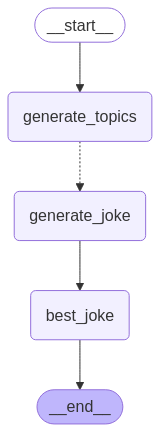

In [46]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

final_graph = graph.compile()
Image(final_graph.get_graph(xray=1).draw_mermaid_png())

In [47]:
final_graph.invoke({"topic": "ducks"})

{'topic': 'ducks',
 'subjects': ['Quacking sounds',
  'Webbed feet',
  'Feathers',
  'Waddling',
  'Duck eggs'],
 'jokes': ['Why did the duck go to the doctor? Because it had a fowl cough!',
  'Why did the man with webbed feet go to the party? Because he heard it was a toe-tally good time!',
  'Why did the feather go to therapy? Because it was feeling a little down!',
  'Why did the duck go to the doctor? It had a fowl cough!',
  'Why did the duck egg go to therapy? Because it was cracking under the pressure!'],
 'best_selected_joke': 'Why did the duck go to the doctor? Because it had a fowl cough!'}

In [48]:
for s in final_graph.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Lion', 'Tiger', 'Elephant', 'Giraffe', 'Zebra']}}
{'generate_joke': {'jokes': ['Why did the tiger go to the party? Because it was a roar-ing good time!']}}
{'generate_joke': {'jokes': ['Why did the elephant quit the circus? Because it was tired of working for peanuts!']}}
{'generate_joke': {'jokes': ['Why did the lion go to the dentist? Because it had a roar-ing toothache!']}}
{'generate_joke': {'jokes': ['Why did the giraffe refuse to play hide and seek? Because he was always a neck above the rest!']}}
{'generate_joke': {'jokes': ['Why did the zebra refuse to play poker? Because he always got striped of his money!']}}
{'best_joke': {'best_selected_joke': 'Why did the lion go to the dentist? Because it had a roar-ing toothache!'}}
